# Data Analysis on the KITTI Dataset

This is an initial analysis of the KITTI Dataset. It should provide basic statistics on the dataset as well as ways to leverage additional information to enrich the dataset.

This notebook will guide the reader through following steps:
* **Hello KITTI!**: How to the dataset can be read into python
* **Initial Statistics**: Basic statistics regarding class distribution and some class parameters
* **The Misc class**: Analyzing what's behind the Misc class
* **Object sizes in the image**: Creating statistics and distributions on the object sizes on the image
* **Object distribution over the driving plane**: Introducing the coverage plot for visual inspection
* **Enriching the dataset with IMU data**: How to add IMU data to the dataset and plot the location of all frames

This is by far no complete analysis of this dataset (just think lidar!). But it should give an initial feeling on what to expect from the dataset as well as some ideas on how to extend the dataset with external data sources.


## Hello KITTI!

The first step is to obtain the dataset. For just the original dataset, following bash-script can be used:
```
mkdir data
cd data
<path_to_code>/get_kitti_data_corpus.sh
```
This script will download and unzip following artefacts:
* The labels for the 3D Object Detection Dataset
* The images for the 3D Object Detection Dataset
* The calibration data 
* The devkit
* The raw data (later needed to enrich the dataset with more information)


Now there should be a data folder with the following structure:
```
data
|-training
  |-calib
  |-image_2
  |-label_2
|-testing
|-raw_data_downloader
```

The second step is to load the data into Python datastructures in order to work with the data.
The relation between label file and image file is given by its filename, therefore only a few parsing and path-joining operations are necessary to ingest the data into Python.

All functionality to ingest the dataset are encapsulated into the module `kitti_reader`. For each frame a dictionary is created containing the following information
* frame (dictionary)
	* image (dictionary)
        * id (str): id of the frame within the dataset
        * path (str): path to the image of the frame
        * width (int): width of the image
        * height (int): height of the image
	* detections (list of dictionaries)
        * label (str): Describes the type of object: 'Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram',                                                  'Misc' or 'DontCare'
        * left, right, top, bottom (int): 2D bounding box of object in the image: contains left, top, right, bottom pixel coordinates
        * truncated (float): Float from 0 (non-truncated) to 1 (truncated), where truncated refers to the object leaving image boundaries
        * occluded (int): Integer (0,1,2,3) indicating occlusion state:                                                     0 = fully visible, 1 = partly occluded, 2 = largely occluded,                                                     3 = unknown
        * alpha (float): Observation angle of object, ranging [-pi..pi]
        * height, width, length (float): 3D object dimensions: height, width, length (in meters)
        * pos_x, pos_y, pos_z (float): 3D object location x,y,z in camera coordinates (in meters)
        * rot_y: Rotation ry around Y-axis in camera coordinates [-pi..pi]



In [1]:
from kitti_reader import KITTIFrameReader

# path to the data folder
path = r'/media/jan/data/blackbox/Blackbox/Documents/projects/AID_Kitti_task/data'

reader = KITTIFrameReader(path)
frames = reader.read_all_frames()


## Initial Statistics

With that, we can already create the very first statistics regarding the dataset. 

From the readme of the dataset, we know the names of the labels. The "DontCare" labels are not really labels, they are regions in the frame, which specifically were not labeled. This is done to avoid accuracy evaluation in these regions, as it is just unknown, if there are objects or if there are not. Therefore the "DontCare" class is omitted during further investigation.

Total number of frames: 7481
Total number of labeled objects: 40570
--------------
Car                            28742       70.8%
Van                             2914        7.2%
Truck                           1094        2.7%
Pedestrian                      4487       11.1%
Person_sitting                   222        0.5%
Cyclist                         1627        4.0%
Tram                             511        1.3%
Misc                             973        2.4%


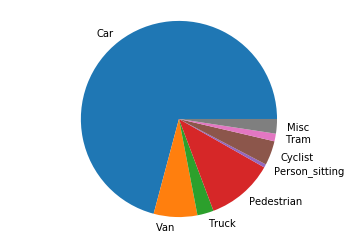

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

label_classes = ['Car', 'Van', 'Truck',
                 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram',
                 'Misc']

detections = {lbl:[] for lbl in label_classes}


for f in frames:
    for lbl in label_classes:
        detections[lbl] += [d for d in f['detections'] if d['label'] == lbl]

total_objects = sum([len(detections[lbl]) for lbl in label_classes])

print(f"Total number of frames: {len(frames)}")
print(f"Total number of labeled objects: {total_objects}")
print("--------------")
for lbl in label_classes:
    print("{:25} {:10d} {:10.1f}%".format(lbl, len(detections[lbl]), len(detections[lbl])/total_objects*100.0))
    
    
plt.pie([len(detections[lbl]) for lbl in label_classes], labels=label_classes)

plt.axis('equal')
plt.show()

Additionally, each class' typical dimensions might be of interest:

In [3]:
import numpy as np

print("{:25} {:22} {:22} {:22} ".format(
        lbl, 
        'length',
        'width',
        'height'
    ))
print("{:-^25}+{:-^22}+{:-^22}+{:-^22} ".format("","","",""))

for lbl in label_classes:
    heights = np.array([d['height'] for d in detections[lbl]])
    widths = np.array([d['width'] for d in detections[lbl]])
    lengths = np.array([d['length'] for d in detections[lbl]])
    print("{:25} {:10.2f}m (std={:3.2f}) {:10.2f}m (std={:3.2f}) {:10.2f}m (std={:3.2f})".format(
        lbl, 
        lengths.mean(), lengths.std(),
        widths.mean(), widths.std(),
        heights.mean(), heights.std()
    ))

Misc                      length                 width                  height                 
-------------------------+----------------------+----------------------+---------------------- 
Car                             3.88m (std=0.43)       1.63m (std=0.10)       1.53m (std=0.14)
Van                             5.08m (std=0.83)       1.90m (std=0.17)       2.21m (std=0.32)
Truck                          10.11m (std=2.86)       2.59m (std=0.22)       3.25m (std=0.45)
Pedestrian                      0.84m (std=0.23)       0.66m (std=0.14)       1.76m (std=0.11)
Person_sitting                  0.80m (std=0.22)       0.59m (std=0.08)       1.27m (std=0.11)
Cyclist                         1.76m (std=0.18)       0.60m (std=0.12)       1.74m (std=0.09)
Tram                           16.09m (std=7.85)       2.54m (std=0.22)       3.53m (std=0.18)
Misc                            3.58m (std=2.86)       1.51m (std=0.67)       1.91m (std=0.81)


These results look reasonable. The car width seems to be a little bit on the smaller side, presumably because side mirrors are not part of the bounding box.

Trucks and Trams have quite a big standard deviation, which also makes sense, as the tram might have a different number of cars and a truck can be a semi or just a truck.

The misc class seems a bit odd with a quite high standard deviation of 2.8m, so let's have a look into that.

## The Misc class

The "Misc" class seems a little bit mysterious. So let's have a look at a few examples.

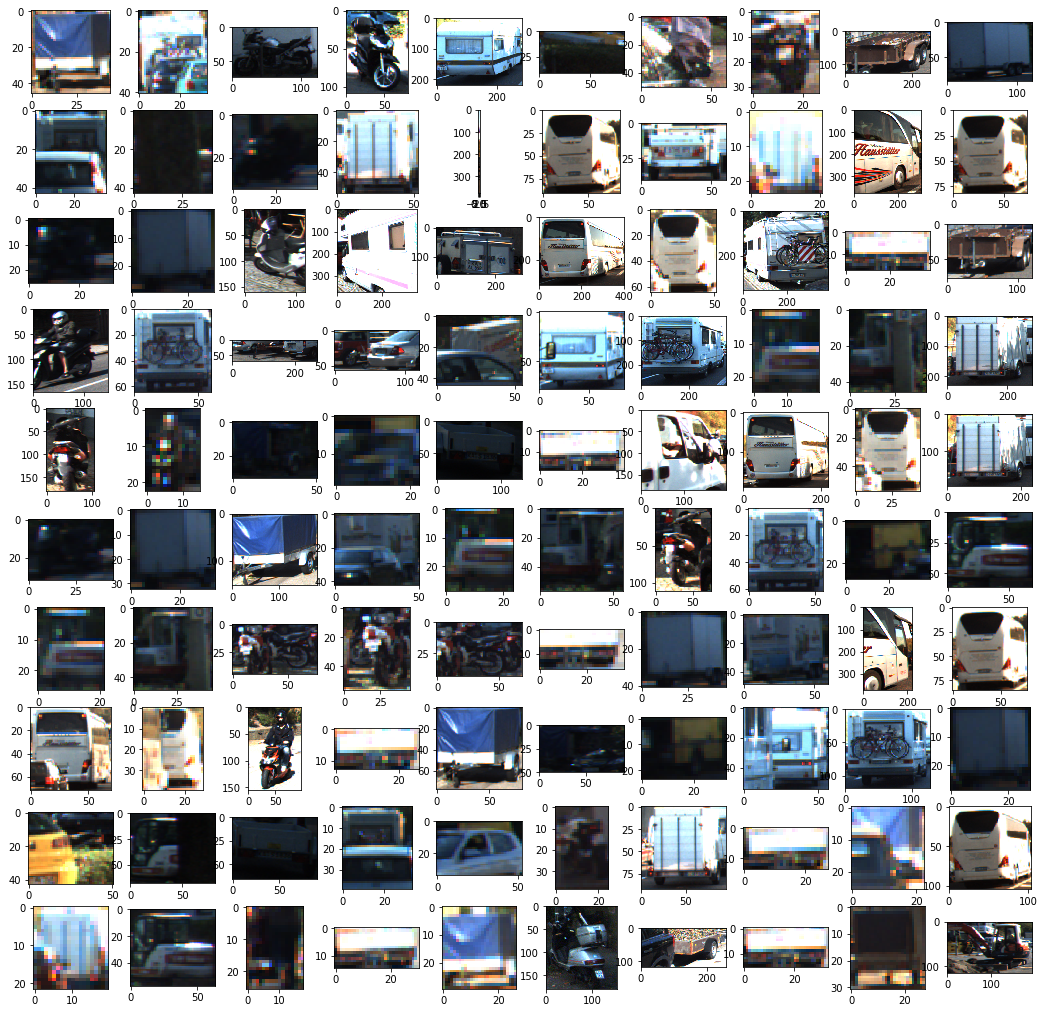

In [5]:
from plot_helpers import plot_detection, crop_detection
grid = (10,10)
fig = plt.figure(figsize=(18, 18))
for idx, data in enumerate([(f,d) for f in frames for d in f['detections'] if d['label']=='Misc']):
    ax = plt.subplot(grid[0],grid[1], idx+1)
    plt.imshow(crop_detection(data[0]['image']['path'], data[1]), aspect="equal")

    if idx >= grid[0]*grid[1]-1:
        break
        
plt.show(fig)


There we go. It seems, that the "Misc"-class contains among others: 
* caravans
* trailers
* motor-bikes/scooters
* coaches
* mini-diggers

Especially for training a neural network I personally think it is hard to train for this particular class. Coaches are much more similiar to trucks an the network will get confused when to predict trucks and when "Misc". I would take special care of this class within evaluation and KPI calculation, as it will be most likely a wrong class prediction (e.g. truck or bicycle instead of misc), but an object should still be detected.

## Object sizes in the image

Besides the physical size of the object, the size in the pixel space is also of interest, as this is the amount of information which is available for a particular object from the image sensor.

Misc                      width (min/mean/max)     height (min/mean/max)    aspect ratio (min/mean/max) 
-------------------------+------------------------+------------------------+------------------------ 
Car                         0.46/111.95/581.42 px  12.67/ 66.12/334.53 px   0.02/  1.72/  3.99 px
Van                         3.24/109.65/537.01 px  16.89/ 83.60/375.00 px   0.01/  1.40/  2.99 px
Truck                       1.83/ 99.72/509.91 px  26.69/ 86.41/375.00 px   0.00/  1.20/  4.36 px
Pedestrian                  0.11/ 43.82/358.42 px  13.52/103.72/294.48 px   0.01/  0.40/  1.41 px
Person_sitting              3.86/ 83.64/230.41 px  31.74/102.28/226.54 px   0.03/  0.82/  2.00 px
Cyclist                     6.21/ 55.85/369.83 px  16.16/ 76.89/294.66 px   0.07/  0.69/  1.87 px
Tram                       24.25/153.41/537.41 px  20.18/104.22/374.00 px   0.25/  1.58/  3.49 px
Misc                        5.04/ 90.72/454.02 px  13.17/ 74.46/375.00 px   0.01/  1.28/  5.16 px


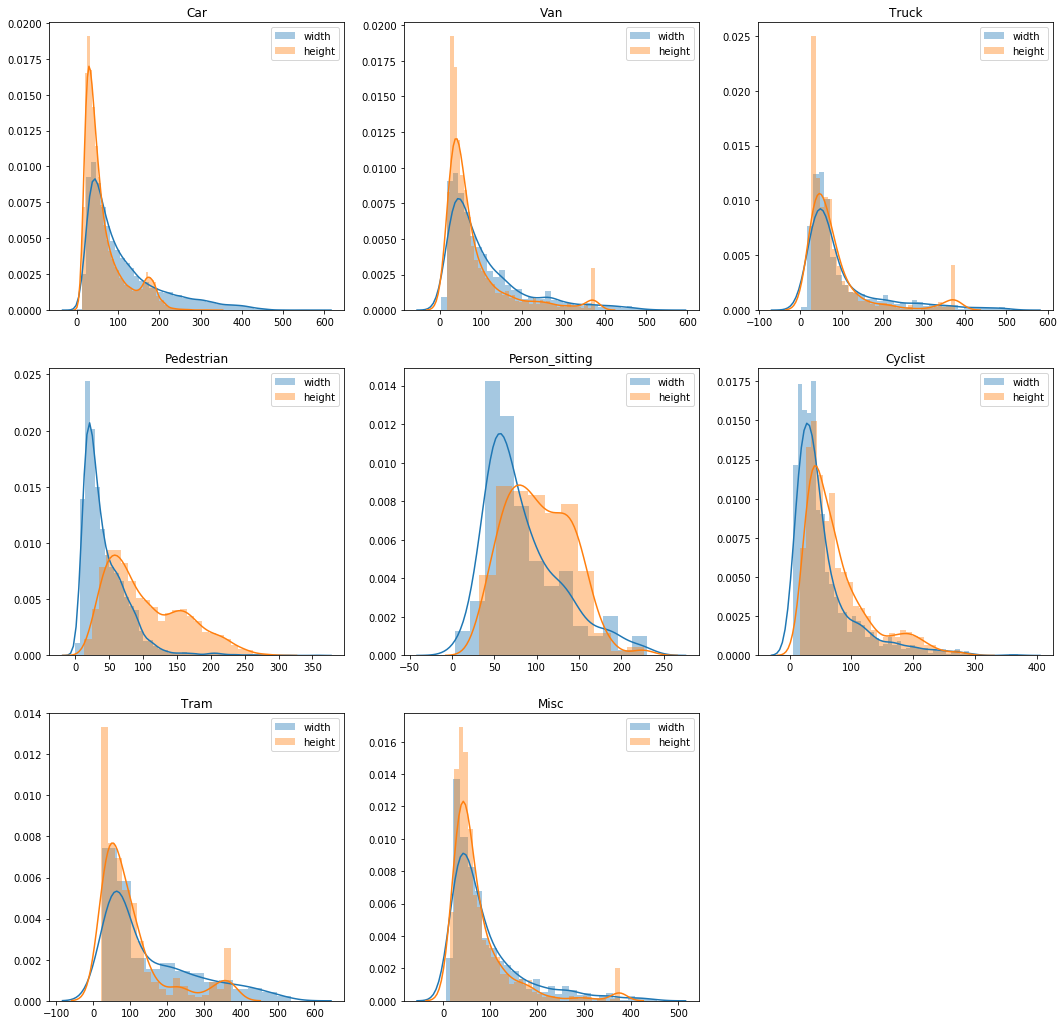

In [6]:
import numpy as np
import seaborn as sbn

print("{:25} {:24} {:24} {:24} ".format(
        lbl, 
        'width (min/mean/max)',
        'height (min/mean/max)',
        'aspect ratio (min/mean/max)'
    ))
print("{:-^25}+{:-^24}+{:-^24}+{:-^24} ".format("","","",""))

fig = plt.figure(figsize=(18, 18))

for idx, lbl in enumerate(label_classes):
    widths = np.array([d['right']-d['left'] for d in detections[lbl]])
    heights = np.array([d['bottom']-d['top'] for d in detections[lbl]])
    aspect = widths/heights
    
    print("{:25} {:6.2f}/{:6.2f}/{:6.2f} px {:6.2f}/{:6.2f}/{:6.2f} px {:6.2f}/{:6.2f}/{:6.2f} px".format(
        lbl, 
        widths.min(), widths.mean(), widths.max(),
        heights.min(), heights.mean(), heights.max(),
        aspect.min(), aspect.mean(), aspect.max(),
    ))
    
    ax = plt.subplot(3,3, idx+1)
    ax.autoscale(axis='both')
    ax.set_title(lbl)
    sbn.distplot(widths, label="width")
    sbn.distplot(heights, label="height")
    ax.legend()
        
plt.show(fig)
    

## Object distribution in the driving plane

To get a feeling for the data, it is always a good idea, to visualize it. In this case, the distribution of the labeled classes should be aggregated, so that it is easy to spot uneven distributions in the location of the classes. Of course, this can be done using histogram plots, but in this case the aggregated birds-eye view provides a much more intuitive way of describing a spatial distribution.

The class `CoveragePlot` creates a birds-eye-view for all given detections.

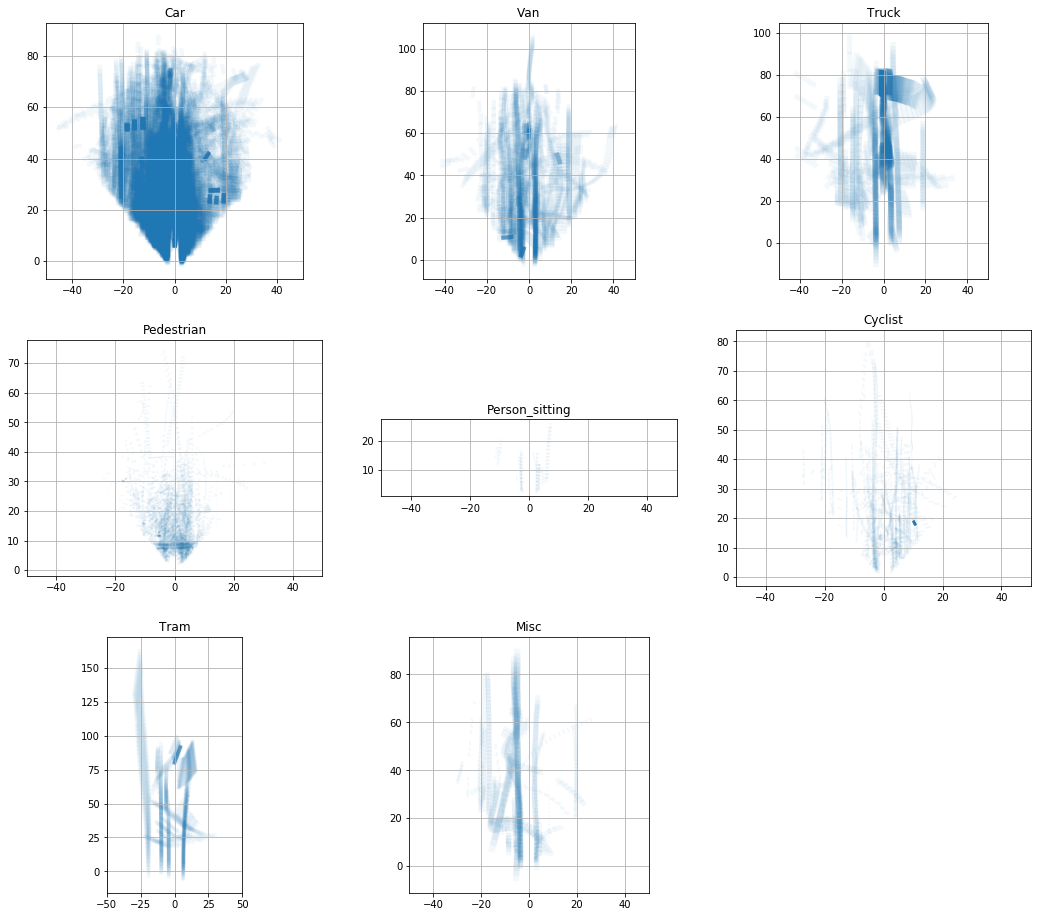

In [7]:
from plot_helpers import CoveragePlot

fig = plt.figure(figsize=(18, 16))
for idx, lbl in enumerate(label_classes):
    ax = plt.subplot(3,3, idx+1)
    CoveragePlot(detections[lbl], ax, 0.05)
    ax.set_xlim([-50, 50])
    ax.set_aspect('equal')
    ax.autoscale(axis='y')
    ax.set_title(lbl)
    ax.grid(True)


plt.show(fig)

These plots make it quite obvious, that only within the car and pedestrian classes all objects are well distributed over the camera perception cone. All other classes have serious white spots. So if this dataset is used to validate the performance of an algorithm, no reliable statement can be given for those white spots.

Additionally, the classes car, van and cyclist contain interesting hot spots - detections, which obviously occur in multiple frames at the exact same position (e.g. at consecutive frames at a traffic light).

## Enriching the dataset with IMU data

According to [ http://www.cvlibs.net/publications/Geiger2013IJRR.pdf ], the dataset was originally recorded with a high precision IMU (OXTS). Unfortunately this information is not included in the 3D Object Detection Evaluation dataset anymore. But as the origins of this dataset are very well documented, one can reconstruct the relation between dataset frame and "raw dataset" frame. 

The accompanying development kit for this dataset (https://s3.eu-central-1.amazonaws.com/avg-kitti/devkit_object.zip) contains valuable information: 

```
--------------------                                                              --------------------
| 3D Obj Det Frame | --> mapping/train_rand.txt --> mapping/train_mapping.txt --> | * drivedate      |
--------------------                                                              | * drivenumber    |
                                                                                  | * frame of drive |
                                                                                  --------------------
```
With this information, one can match the labeled frames to the raw data. This mapping function is implemented in the `kitti_reader.KITTIRawEnhancer` class. The raw data is read using the open source 'pykitti' module and then the releavant information is stored within the before mentioned frame dictionary by just adding a key to the dictionary. For now, only adding the IMU information is implemented.

In [8]:
from kitti_reader import KITTIRawEnhancer

enhancer_raw = KITTIRawEnhancer(r'/media/jan/data/blackbox/Blackbox/Documents/projects/AID_Kitti_task/data/',
                                r'/media/jan/data/blackbox/Blackbox/Documents/projects/AID_Kitti_task/code/devkit_object/mapping')

frames = [enhancer_raw.enhance_oxts(fr) for fr in frames if enhancer_raw.raw_exists_for_frame(fr)]

Now the `frames` list contains dictionaries with an additional key called `oxts`, which contains all the IMU data, including the GPS coordinates. For now, here is only a visualization of all the frames on a map, but this opens up much more possibilities, which would exceed the available time at hand for this task. 

In [9]:
import gmaps
import pandas as pd
import gmaps.datasets
gmaps.configure(api_key="<YOUR_GMAPS_API_KEY_HERE>") # Your Google API key


df = pd.DataFrame([{'latitude': f['oxts'][0].packet.lat, 'longitude':f['oxts'][0].packet.lon} for f in frames])

df = df.iloc[::10,:] # only every 10th point to keep jupyter notebook responsive

frame_layer = gmaps.symbol_layer(
    df, fill_color="green", stroke_color="green", scale=2
)
fig = gmaps.figure()
fig.add_layer(frame_layer)

fig

Figure(layout=FigureLayout(height='420px'))

By not only using one GPS point, but multiple points, map matching could be applied on a map (e.g. Open Street Maps) in order to get the node on which the recording vehicle was located. And with that even more meta data can be applied: 
* number of lanes
* potential intersections in sight
* availability of sidewalks
* potential traffic signs or traffic lights in sight
* ...

The things to add are just limited by the creativity of queries to the map database.

In order to connect the dataset to the map database, I would pursue following steps:
1. setting up the open source routing matching using docker (see https://github.com/Project-OSRM/osrm-backend)
2. setup an OSRM python binding (e.g. https://github.com/ustroetz/python-osrm)
3. Query OSRM map matching for a short sequence of GPS points for a given frame within the dataset
4. Use the map matched result in order to do further queries (e.g. for number of lanes) directly to a Open Street map database, as the link node id now is known
